I decided to implemet following models for the classificationpurpose - K nearest neighbors (KNN), Support Vector machines (SVM) and Random Forest; KNN being the baseline. From results on validation set, I observed that Random Forest is most efficient both in terms of time and accuracy. And I decided to implement that as my final model.

A. Before getting started, I processed the data as follows -
1. Filtered the data for valid output variable (drop samples having 'state' other than 'successful' / 'fail') and convert categorical 'state' variable to numerical. 
2. Performed test, train and validation split. Used train + validation data for exploration.
3. Checked for missing values.

B. My data analysis includes following steps - 
1. Intuitively guessed correlation amongst features and verified the assumption by data visualization.
2. Acquired frequeny distribution for the categorical variables.
3. Perfomed some feature processing and analyzed correlation among all variables under consideration.

# A. Data Processing

In [64]:
# A.1,3 Check present output variable attributes
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
"%matplotlib inline"
import seaborn as sns

all_data = pd.read_csv('data.csv')

print(set(all_data['state']))

{'successful', 'undefined', 'live', 'suspended', 'canceled', 'failed'}


In [65]:
#Checked for missing values in the train data.(used filtered data from previous step)
all_data = pd.read_csv('train.csv')
print(all_data.isnull().sum())

ID                    0
name                  2
category              0
main_category         0
currency              0
deadline              0
goal                  0
launched              0
pledged               0
state                 0
backers               0
country               0
usd pledged         133
usd_pledged_real      0
usd_goal_real         0
dtype: int64


# B. Data analysis

From the description of the data features, I made following guesses/conclusions:
1. 'ID', 'name' - Redundant
2. 'category' is subset of 'main_category', hence the 2 can be correlated. Should be using only 1 of them. It is likely that correlation exists in following sets as well  -
> a. 'currency', 'country'  
> b. 'goal', 'usd_goal_real'  
c. 'backers', 'pledged', 'usd pledged', 'usd_pledged_real'
3. 'deadline' and 'launched' - It is very rare that these features will matter individually but there difference - 'span' of     project is likely to be a significant feature. Created 'span' feature by using time stamp of the 2 dates.

I verified these assumptions by plotting them and getting correlation matrix. 

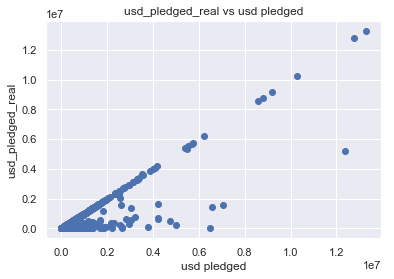

In [66]:
plt.scatter(all_data['usd_pledged_real'], all_data['usd pledged'])
plt.title('usd_pledged_real vs usd pledged')
plt.ylabel('usd_pledged_real', fontsize=12)
plt.xlabel('usd pledged', fontsize=12)
plt.show()

I created similar plots for -
1. 'goal' vs 'usd_goal_real'
2. 'backers' vs 'pledged', 
3. 'pledged', 'usd_pledged_real'

And their correlation was verified.
Then explored the frequency distribution corresponding to categorucal features as 'currency', 'country', 'category' and 'main_category' by data visualization.

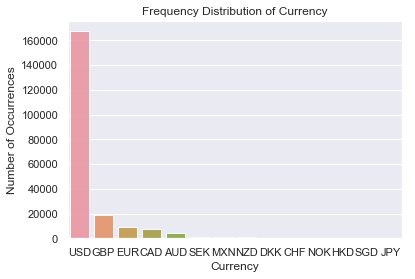

In [6]:
currency_count = all_data['currency'].value_counts()
sns.set(style="darkgrid")
sns.barplot(currency_count.index, currency_count.values, alpha=0.9)
plt.title('Frequency Distribution of Currency')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Currency', fontsize=12)
plt.show()


It was seen that distribution for 'currency' and 'country' was skewed as seen above. But 'category' and 'main_category' had non skewed distribution as below. Hence decided to discard 'currency' and 'country'.

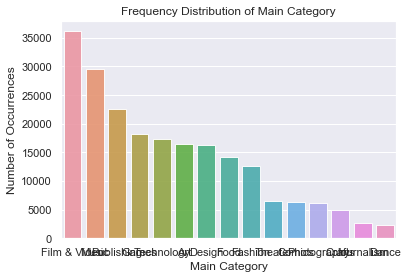

In [7]:
main_category_count = all_data['main_category'].value_counts()
sns.set(style="darkgrid")
sns.barplot(main_category_count.index, main_category_count.values, alpha=0.9)
plt.title('Frequency Distribution of Main Category')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Main Category', fontsize=12)
plt.show()

Before proceeding towards getting correlation, performed some data processing - 
1. Included 'span' feature.
2. Created a copy having numerical data only.
3. Normalized the data.


In [8]:
#1
d2 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) for date in all_data.deadline ]
d1 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()) for date in all_data.launched ]
span = [d2[i] - d1[i] for i in range(len(d1))]

data_1 = all_data
data_1['span'] = span	
data_1 = data_1.drop(['ID'], axis = 1)

#2 and #3
data_1 = data_1.select_dtypes(exclude=['object'])
scaled_data = (data_1-data_1.min())/(data_1.max()-data_1.min())

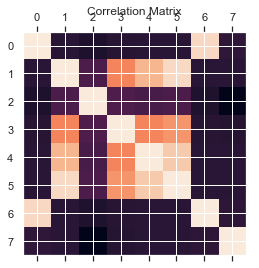

In [9]:
cr = scaled_data.corr()
cr.to_csv('cor.csv', index=False)

plt.matshow(cr)
plt.title('Correlation Matrix')
plt.show()


Numerically, correlation matrix looks like -

In [115]:
corr_mat = pd.read_csv('cor.csv')
corr_mat

.1            .2 CORR. MATRIX           .3  \
0          goal      pledged         state      backers  usd pledged   
1             1  0.008347692  -0.025576424   0.00537052  0.007389172   
2   0.008347692            1   0.106986267  0.716377009  0.844900016   
3  -0.025576424  0.106986267             1  0.117687206   0.09576025   
4    0.00537052  0.716377009   0.117687206            1  0.714015531   
5   0.007389172  0.844900016    0.09576025  0.714015531            1   
6   0.006703028  0.947994665   0.106367578  0.758345269  0.900574896   
7   0.944361848  0.006332761  -0.023864685  0.005806018  0.008012128   
8   0.024208067  0.009433859  -0.116141796  0.000765901  0.009157836   

                 .4             .5            .6  
0  usd_pledged_real  usd_goal_real          span  
1       0.006703028    0.944361848   0.024208067  
2       0.947994665    0.006332761   0.009433859  
3       0.106367578   -0.023864685  -0.116141796  
4       0.758345269    0.005806018   0.000765901  
5       0.900574896    0.008012128   0.009157836  
6                 1    0.007138544   0.009976482  
7       0.007138544              1   0.022559344  
8       0.009976482    0.022559344             1

Initially, I excluded catagorical features.And applied following models -

1. I applied KNN algorithm. It felt intuitive to edit 'weight' parameter in KNeighborsClassifier from 'uniform' to 'distance' - where weight on all nighbours is inversely proportional to their distance from the sample.
2. I also applied KNN on data including categorical features.But error didn't get better.
3. I tried SVM but there were two problems with SVM - a. Inaccuracy was very high, b. time required for prediction was considerably high.
4. Random Forest - I tried changing number of trees in random forest and using 'entropy' instead of 'gini index' as criterion. But default model gave the best results. 

Ran Random forest on data including categorical features.
Here are the results I got.

In [117]:
observations = pd.read_csv('errors_for_models.csv')
observations

.1  \
0   # neighbors       error with 'uniform' weight   
1             5                             11.79   
2            50                              14.7   
3           150                             17.77   
4           300                              19.9   
5           460                             21.56   
6           700                             22.93   
7          1500                             25.61   
8                                                   
9                                                   
10          SVM                           default   
11  Rand Forest                           default   
12                                   # trees = 50   
13                          criterion = 'entropy'   
14               combining 50 trees and 'entropy'   
15                                                  

                              .2                     Categorical  
0   error with 'distance' weight     error with 'uniform' weight  
1                          11.37                           17.91  
2                          12.73                                  
3                          14.56                                  
4                          14.56                                  
5                          16.98                                  
6                          17.93                                  
7                          19.71                                  
8                                                                 
9                                                                 
10                            40                                  
11                          3.41                             1.9  
12                          3.35                            1.85  
13                           3.5                            1.84  
14                           3.2                            1.79  
15

In [69]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pickle
import copy
"%matplotlib inline"
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import BackwardDifferenceEncoder

data_1 = pd.read_csv('data_train.csv')
train_y = pd.read_csv('train_y.csv')
data_1 = data_1.drop(['ID', 'name', 'currency', 'pledged', 'usd pledged', 'goal', 'backers', 'country', 'category'], axis = 1)	

# scale data ========================================================== #3 =================================================

d2 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) for date in data_1.deadline ]
d1 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()) for date in data_1.launched ]
span = [d2[i] - d1[i] for i in range(len(d1))]
data_1['span'] = span
data_1 = data_1.drop(['deadline', 'launched'], axis = 1)	
	
data_2 = data_1.select_dtypes(exclude=['object'])
scaled_data = (data_2-data_2.min())/(data_2.max()-data_2.min())

my_data_1 = scaled_data

knn = KNeighborsClassifier(n_neighbors = 5) 
knn.fit(my_data_1, train_y.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [70]:
# Saved the model
knn_pkl = open('knn_model_5_no_cata.pkl', 'wb')
pickle.dump(knn, knn_pkl)
knn_pkl.close() 

Then got the predictions on validation set and mean squared error

In [71]:
data1 = pd.read_csv('data_val.csv')
val_y = pd.read_csv('val_y.csv')
data1 = data1.drop(['ID', 'name', 'currency', 'pledged', 'usd pledged', 'goal', 'backers', 'country', 'category'], axis = 1)	

# scale data ========================================================== #3 =================================================

d2 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) for date in data1.deadline ]
d1 = [ time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d %H:%M:%S").timetuple()) for date in data1.launched ]
span = [d2[i] - d1[i] for i in range(len(d1))]
data1['span'] = span
data1 = data1.drop(['deadline', 'launched'], axis = 1)	
	
data2 = data1.select_dtypes(exclude=['object'])
scaledData = (data2-data2.min())/(data2.max()-data2.min())

In [72]:
y = knn.predict(scaledData)

In [73]:
y_val1 = [item for sublist in val_y.values for item in sublist]
mse = (((y - y_val1) ** 2).sum()) / len(y)
mse

0.11749076656365418

In [20]:
KNN = KNeighborsClassifier(n_neighbors=5, weights= 'distance')
KNN.fit(my_data_1, train_y.values.ravel())

# Saved the model
KNN_pkl = open('KNN_model_5_no_cata_dist.pkl', 'wb')
pickle.dump(KNN, KNN_pkl)
KNN_pkl.close() 

Y = KNN.predict(scaledData)

mse = (((Y - y_val1) ** 2).sum()) / len(Y)
mse

0.11049973618753298

Included categorical features in the data using 'get_dummies' function. Since this function generates dummies for each category, it will make the data linearly dependent. So I dropped one of these cotegories.

In [74]:
# include categorical features - train
data_cate = pd.get_dummies(data_1)
for i in list(scaled_data):
    data_cate[i] = scaled_data[i]
data_cate = data_cate.drop(['main_category_Art'], axis = 1) # Dropped feature 'main_category_Art' from the data for linear independence.

# same for validation data      
data_cate_val = pd.get_dummies(data1)
for i in list(scaledData):
    data_cate_val[i] = scaledData[i]
    
data_cate_val = data_cate_val.drop(['main_category_Art'], axis = 1) # Dropped feature 'main_category_Art' from the data for linear independence.


In [24]:
data_cate_val.head()

usd_pledged_real  usd_goal_real      span  main_category_Comics  \
0          0.003109       0.000009  0.318478                     0   
1          0.000853       0.000064  0.448562                     0   
2          0.000277       0.000018  0.501975                     0   
3          0.000000       0.000136  0.319138                     0   
4          0.000008       0.000109  0.317669                     0   

   main_category_Crafts  main_category_Dance  main_category_Design  \
0                     0                    0                     0   
1                     0                    0                     0   
2                     0                    0                     0   
3                     0                    0                     0   
4                     0                    0                     0   

   main_category_Fashion  main_category_Film & Video  main_category_Food  \
0                      0                           0                   0   
1                      0                           0                   0   
2                      0                           0                   0   
3                      0                           0                   0   
4                      0                           0                   0   

   main_category_Games  main_category_Journalism  main_category_Music  \
0                    0                         0                    0   
1                    0                         0                    1   
2                    0                         0                    0   
3                    0                         0                    0   
4                    0                         0                    0   

   main_category_Photography  main_category_Publishing  \
0                          0                         0   
1                          0                         0   
2                          0                         0   
3                          0                         0   
4                          0                         1   

   main_category_Technology  main_category_Theater  
0                         1                      0  
1                         0                      0  
2                         0                      1  
3                         1                      0  
4                         0                      0

In [75]:
knn.fit(data_cate, train_y.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [76]:
y_cate = knn.predict(data_cate_val)


In [77]:
mse = (((y_cate - y_val1) ** 2).sum()) / len(y_cate)
mse


0.1790909776136278

As seen, the error infact increased after including categorical features. 
Beacuse of time required to train and predict data with categorical features was causing some system problems, I decided to build the model using numerical features only.

In [57]:
from sklearn import svm
clf = svm.SVC()
clf.fit(my_data_1, train_y.values.ravel())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [60]:
y_svm = clf.predict(scaledData)

In [63]:
mse = (((y_svm - y_val1) ** 2).sum()) / len(y_svm)
mse

0.4000150749981156

In [78]:
KNN = KNeighborsClassifier(n_neighbors=5, weights= 'distance')
KNN.fit(data_cate, train_y.values.ravel())


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='distance')

In [79]:
y = KNN.predict(data_cate_val)
y

array([1, 1, 1, ..., 0, 1, 0], dtype=int64)

In [80]:
mse = (((y - y_val1) ** 2).sum()) / len(y)
mse

0.17123313484585814

In [108]:
from sklearn.ensemble import RandomForestClassifier
my_model = RandomForestClassifier()
my_model.fit(my_data_1, train_y.values.ravel())
y_forest = my_model.predict(scaledData)

In [109]:
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.03672646415919198

In [83]:
my_model = RandomForestClassifier(n_estimators = 30)
my_model.fit(my_data_1, train_y.values.ravel())
y_forest = my_model.predict(scaledData)
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.034597120675359916

In [84]:
my_model = RandomForestClassifier(criterion = 'entropy')
my_model.fit(my_data_1, train_y.values.ravel())
y_forest = my_model.predict(scaledData)
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.03504937061882867

In [85]:
my_model = RandomForestClassifier(n_estimators = 50, criterion = 'entropy')
my_model.fit(my_data_1, train_y.values.ravel())
y_forest = my_model.predict(scaledData)
mse = (((y_forest - y_val1) ** 2).sum()) / len(y)
mse

0.03235471470566066

In [110]:
from sklearn.ensemble import RandomForestClassifier
my_model_final = RandomForestClassifier()
my_model_final.fit(data_cate, train_y.values.ravel())
y_forest = my_model_final.predict(data_cate_val)

In [111]:
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.019182935102133113

In [105]:
my_model = RandomForestClassifier( criterion = 'entropy')
my_model.fit(data_cate, train_y.values.ravel())
y_forest = my_model.predict(data_cate_val)

In [100]:
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.01854224768221904

In [101]:
my_model = RandomForestClassifier( n_estimators = 50)
my_model.fit(data_cate, train_y.values.ravel())
y_forest = my_model.predict(data_cate_val)

In [102]:
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.018504560186929978

In [103]:
my_model = RandomForestClassifier( n_estimators = 50, criterion = 'entropy')
my_model.fit(data_cate, train_y.values.ravel())
y_forest = my_model.predict(data_cate_val)

In [104]:
mse = (((y_forest - y_val1) ** 2).sum()) / len(y_forest)
mse

0.017958091505238562

In [112]:
RF_pkl_cate = open('RF_def_cate.pkl', 'wb')
pickle.dump(my_model_final, RF_pkl_cate)
RF_pkl_cate.close()
(list(data_cate_val))

['usd_pledged_real',
 'usd_goal_real',
 'span',
 'main_category_Comics',
 'main_category_Crafts',
 'main_category_Dance',
 'main_category_Design',
 'main_category_Fashion',
 'main_category_Film & Video',
 'main_category_Food',
 'main_category_Games',
 'main_category_Journalism',
 'main_category_Music',
 'main_category_Photography',
 'main_category_Publishing',
 'main_category_Technology',
 'main_category_Theater']